# Action Sequence Graph Tutorial

This tutorial covers use of the Action Sequence Graph in the FxnBlock class, which is useful for representing a Function's progress through a sequence of actions (e.g., modes of operation, etc)..

In [1]:
# for use in development - makes sure git version is used instead of pip-installed version
import sys, os
sys.path.insert(1,os.path.join(".."))

from fmdtools.modeldef import *
import fmdtools.resultdisp as rd
import fmdtools.faultsim.propagate as prop

Action sequence graphs are used within a function block to represent the actions that the function performs and their sequence. Actions in an ASG are respresented by `Action` blocks, which are similar to function and component blocks in that they have:
- flow connections
- modes, and
- behaviors

Flow connections are routed to the action in the function block definition and represent the *shared variables* between the actions.

Modes are similar to function modes and are instantiated (as they are in components) at both the Function and Action level. Using the `name=` option enables one to tag these modes as action modes at the function level while using the same local name


Below we define three actions for use in a given model:
- Perceive, a user's perception abilities/behaviors. In this function the user percieves a hazard (unless their perception fails)
- Act, the user's action which they perform to mitigate the hazard.
- Done, the user's state when they are done performing the action.

In [2]:
class Perceive(Action):
    def __init__(self, name, flows):
        super().__init__(name,flows)
        self.assoc_modes({'failed'}, exclusive=True, name="perceive_")
    def behavior(self,time):
        if not self.in_mode('failed'): 
            self.Hazard.percieved = self.Hazard.present
            self.Outcome.num_perceptions+=self.Hazard.percieved
        else: self.Hazard.percieved = False; self.remove_fault('failed', 'nom')
    def percieved(self):
        return self.Hazard.percieved
class Act(Action):
    def __init__(self, name, flows):
        super().__init__(name,flows)
        self.assoc_modes({'failed', 'unable'}, exclusive=True, name="act_")
    def behavior(self,time):
        if not self.in_mode('failed', 'unable'): 
            self.Outcome.num_actions+=1
            self.Hazard.mitigated=True
        elif self.in_mode('failed'): 
            self.Hazard.mitigated=False; self.remove_fault('failed', 'nom')
        else: self.Hazard.mitigated=False
    def acted(self):
        return not self.in_mode('failed')
class Done(Action):
    def __init__(self, name, flows):
        super().__init__(name,flows)
    def behavior(self,time):
        if not self.Hazard.present: self.Hazard.mitigated=False
    def ready(self):
        return not self.Hazard.present

To proceed through the sequence of actions, *conditions* must be met between each action. In these actions, we have defined the following conditions:
- Percieve.percieved: perception is done if the hazard is percieved
- Act.acted: the action is complete if the action was performed
- Done.complete: the hazard mitigation is over (and mitigated state is reset to False)

To create the overall ASG structure, the following adds the flows, actions, and conditions to the function block.

In [3]:
class DetectHazard(FxnBlock):
    def __init__(self,name, flows):
        super().__init__(name, flows)
        self.add_flow('Outcome', {'num_perceptions':0, 'num_actions':0})
        
        self.add_act("Perceive", Perceive, self.Outcome, self.Hazard)
        self.add_act("Act", Act, self.Outcome, self.Hazard)
        self.add_act("Done", Done, self.Outcome, self.Hazard)
        
        self.add_cond("Perceive","Act", "Percieved", self.Perceive.percieved)
        self.add_cond("Act","Done", "Acted", self.Act.acted)
        self.add_cond("Done", "Perceive", "Ready", self.Done.ready)
        self.assoc_modes(exclusive=True)
        self.build_ASG(initial_action="Perceive", asg_proptype='dynamic')

Note the use of the following methods:
- add_flow adds an *internal flow*--a flow used to connect actions that does not leave the function. Here *Outcome* is an internal flow, while *Hazard* is an external flow.

In [4]:
help(FxnBlock.add_flow)

Help on function add_flow in module fmdtools.modeldef:

add_flow(self, flowname, flowdict={}, flowtype='')
    Adds a flow with given attributes to the Function Block
    
    Parameters
    ----------
    flowname : str
        Unique flow name to give the flow in the function
    flowattributes : dict, Flow, set or empty set
        Dictionary of flow attributes e.g. {'value':XX}, or the Flow object.
        If a set of attribute names is provided, each will be given a value of 1
        If an empty set is given, it will be represented w- {flowname: 1}



- add_act adds the action to the function and hands it the given flows and parameters. Here the actions are "Percieve", "Act", and "Done"

In [5]:
help(FxnBlock.add_act)

Help on function add_act in module fmdtools.modeldef:

add_act(self, name, action, *flows, duration=0.0, **params)
    Associate an Action with the Function Block for use in the Action Sequence Graph
    
    Parameters
    ----------
    name : str
        Internal Name for the Action
    action : Action
        Action class to instantiate
    *flows : flow
        Flows (optional) which connect the actions
    **params : any
        parameters to instantiate the Action with.



- add_cond specifies the conditions for going from one action to another.

In [6]:
help(FxnBlock.add_cond)

Help on function add_cond in module fmdtools.modeldef:

add_cond(self, start_action, end_action, name='auto', condition='pass')
    Associates a Condition with the Function Block for use in the Action Sequence Graph
    
    Parameters
    ----------
    start_action : str
        Action where the condition is checked
    end_action : str
        Action that the condition leads to.
    name : str
        Name for the condition. Defaults to numbered conditions if none are provided.
    condition : method
        Method in the class to use as a condition. Defaults to self.condition_pass if none are provided



- build_ASG finally constructs the structure of the ASG (see: self.action_graph and self.flow_graph) and determines the settings for the simulation. In DetectHazard, default options are used, with the first action specified as "Percieve" and also with it specified that the actions propagate in the dynamic step (rather than static step)

In [7]:
help(FxnBlock.build_ASG)

Help on function build_ASG in module fmdtools.modeldef:

build_ASG(self, initial_action='auto', state_rep='finite-state', max_action_prop='until_false', mode_rep='replace', asg_proptype='dynamic', per_timestep=False, asg_pos={})
    Constructs the Action Sequence Graph with the given parameters.
    
    Parameters
    ----------
    initial_action : str/list
        Initial action to set as active. Default is 'auto'
            - 'auto' finds the starting node of the graph and uses it
            - 'ActionName' sets the given action as the first active action
            - providing a list of actions will set them all to active (if multi-state rep is used)
    state_rep : 'finite-state'/'multi-state'
        How the states of the system are represented. Default is 'finite-state'
            - 'finite-state' means only one action in the system can be active at once (i.e., a finite state machine)
            - 'multi-state' means multiple actions can be performed at once
    max_action_

Below we first instantiate the function to how how it (and the ASG) simulates on its own 

In [15]:
Hazard = Flow({"present":False, "percieved":False, "mitigated":False},'Hazard')
ex_fxn = DetectHazard('DetectHazard', [Hazard])
ex_fxn.set_timestep(local_tstep=1.0)

We can now view the ASG show_ASG()

In [16]:
help(FxnBlock.show_ASG)

Help on function show_ASG in module fmdtools.modeldef:

show_ASG(self, gtype='combined', with_cond_labels=True, pos=[])
    Shows a visual representation of the internal Action Sequence Graph of the Function Block
    
    Parameters
    ----------
    gtype : 'combined'/'flows'/'actions'
        Gives a graphical representation of the ASG. Default is 'combined'
        - 'actions'     (for function input):    plots the sequence of actions in the function's Action Sequence Graph
        - 'flows'       (for function input):    plots the action/flow connections in the function's Action Sequence Graph
        - 'combined'    (for function input):    plots both the sequence of actions in the functions ASG and action/flow connections
    with_cond_labels: Bool
        Whether or not to label the conditions
    pos : dict
        Dictionary of node positions for actions/flows



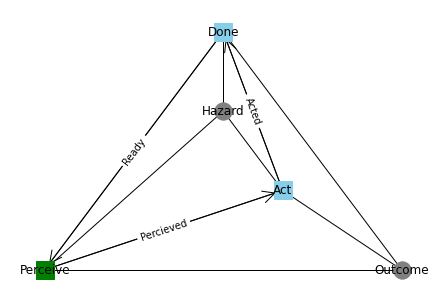

In [17]:
fig = ex_fxn.show_ASG()

In [18]:
#%matplotlib qt
#rd.graph.set_pos(ex_fxn, 'combined')

In [19]:
#%matplotlib inline

As shown, the "Percieve" action is active (green), while the inactive actions are shown in blue. This action is active because it is the initial action here.

If we update the action, we can see the ASG progress between states:

In [20]:
ex_fxn.Hazard.present=True
ex_fxn.updatefxn('dynamic', time= 1)

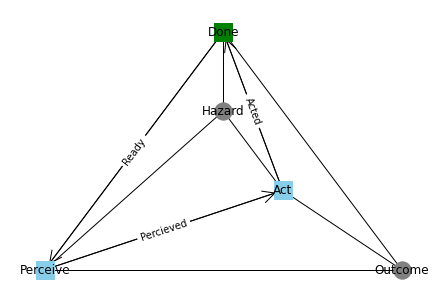

In [21]:
fig = ex_fxn.show_ASG()

In [22]:
ex_fxn.Hazard

Hazard generic flow: {'present': True, 'percieved': True, 'mitigated': True}

In [23]:
ex_fxn.Outcome

Outcome Outcome flow: {'num_perceptions': 1, 'num_actions': 1}

As shown, each of the actions are progressed throuh in a single timestep until the ASG is in the "Done" action

In [24]:
ex_fxn.Hazard.present= False
ex_fxn.updatefxn('dynamic', time= 2)

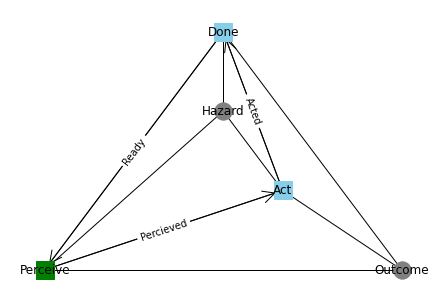

In [25]:
fig = ex_fxn.show_ASG()

In [26]:
ex_fxn.Outcome

Outcome Outcome flow: {'num_perceptions': 1, 'num_actions': 1}

In [27]:
ex_fxn.Hazard

Hazard generic flow: {'present': False, 'percieved': False, 'mitigated': False}

As shown, now that the hazard is no longer present, the "Ready" Condition is triggered and the ASG goes back to the percieve state.

Below, this function is placed in the context of a model so we can see how it behaves in the context of a simulation

In [28]:
class ProduceHazard(FxnBlock):
    def __init__(self,name, flows):
        super().__init__(name, flows)
    def dynamic_behavior(self,time):
        if not time%4: self.Hazard.present=True
        else:          self.Hazard.present=False
class PassHazard(FxnBlock):
    def __init__(self,name, flows):
        super().__init__(name, flows, states={'hazards_mitigated':0, 'hazards_propagated':0})
    def dynamic_behavior(self,time):
        if self.Hazard.present and self.Hazard.mitigated:       self.hazards_mitigated+=1
        elif self.Hazard.present and not self.Hazard.mitigated: self.hazards_propagated+=1

class HazardModel(Model):
    def __init__(self, params={}, modelparams={'times':[0,60], 'tstep':1}, valparams={}):
        super().__init__(params,modelparams,valparams)
        
        self.add_flow("Hazard", {"present":False, "percieved":False, "mitigated":False})
        
        self.add_fxn("ProduceHazard", ['Hazard'],  ProduceHazard)
        self.add_fxn("DetectHazard",['Hazard'], DetectHazard)
        self.add_fxn("PassHazard", ['Hazard'], PassHazard)
        self.build_model()

In [29]:
mdl = HazardModel()
endstate, resgraph, mdlhist = prop.nominal(mdl)

Below we look at the states of the functions/flows to see how this has simulated.

In [30]:
restab = rd.tabulate.hist(mdlhist)

In [31]:
restab['DetectHazard']

,mode,Act_t_loc,Act_mode,Perceive_t_loc,Perceive_mode,Done_t_loc,Outcome_num_perceptions,Outcome_num_actions
0,Perceive,0.0,nom,0.0,nom,0.0,0,0
1,Perceive,0.0,nom,1.0,nom,0.0,0,0
2,Perceive,0.0,nom,2.0,nom,0.0,0,0
3,Perceive,0.0,nom,3.0,nom,0.0,0,0
4,Done,0.0,nom,0.0,nom,1.0,1,1
...,...,...,...,...,...,...,...,...
56,Done,0.0,nom,0.0,nom,1.0,14,14
57,Perceive,0.0,nom,1.0,nom,0.0,14,14
58,Perceive,0.0,nom,2.0,nom,0.0,14,14
59,Perceive,0.0,nom,3.0,nom,0.0,14,14


As shown, the ASG alternates between Perceive (when the hazard is not present) and Done (when the hazard is present)

In [32]:
restab['Hazard']

,present,percieved,mitigated
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,True,True,True
...,...,...,...
56,True,True,True
57,False,False,False
58,False,False,False
59,False,False,False


As a result, all of the present hazards (above) are also perceived and mitigated.

In [33]:
restab['PassHazard']

,hazards_mitigated,hazards_propagated
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
...,...,...
56,14,0
57,14,0
58,14,0
59,14,0


And as a result no hazards are propagated.

Or, in plot form:

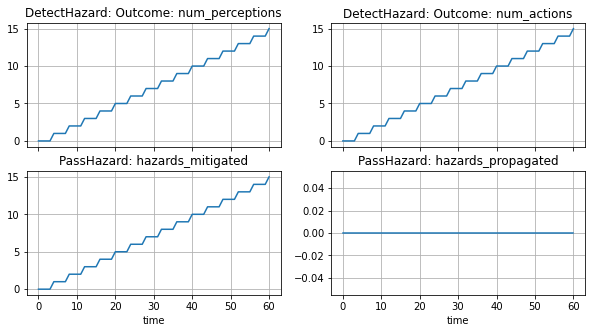

In [34]:
fig, axs = rd.plot.mdlhists(mdlhist, fxnflowvals={'DetectHazard':'Outcome', 'PassHazard':'all'}, figsize=(10,5))

As shown, perceptions and actions track the hazards mitigated.

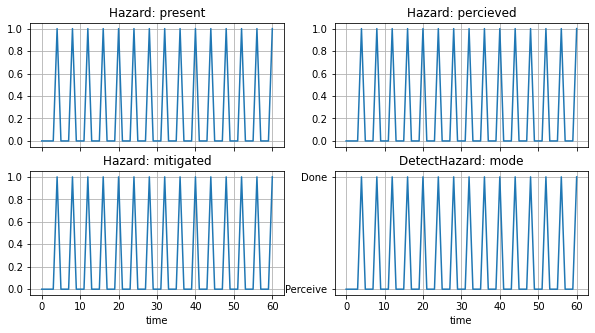

In [35]:
fig, axs = rd.plot.mdlhists(mdlhist, fxnflowvals={'Hazard':'all', 'DetectHazard':'mode'}, figsize=(10,5))

And the mode tracks the presence of the hazard.

ASGs can also be viewed using the `resultdisp.graph` module. Below we will simulate a fault and see how it tracks in the model.

In [36]:
endstate_fault, resgraph_fault, mdlhist_fault = prop.one_fault(mdl, 'DetectHazard','perceive_failed', time=4)

As shown, this fault results in the hazard not being perceived (and thus the hazard propagating)

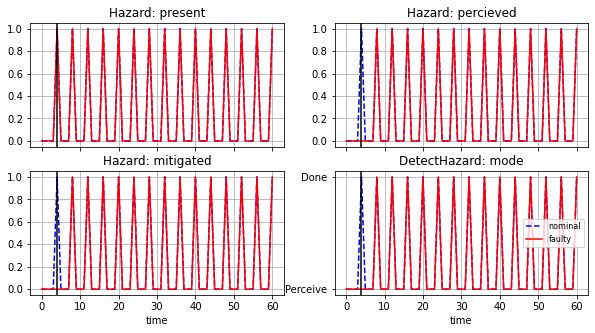

In [37]:
fig, axs = rd.plot.mdlhists(mdlhist_fault, fxnflowvals={'Hazard':'all', 'DetectHazard':'mode'}, figsize=(10,5), time_slice=[4])

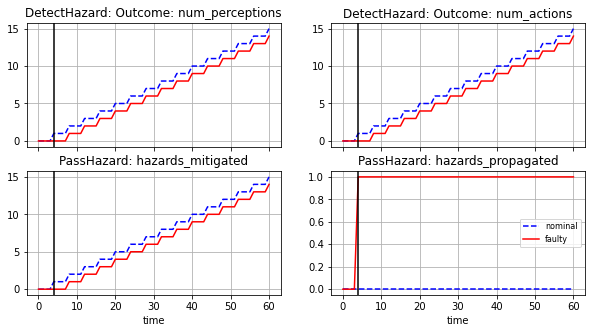

In [38]:
fig, axs = rd.plot.mdlhists(mdlhist_fault, fxnflowvals={'DetectHazard':'Outcome', 'PassHazard':'all'}, figsize=(10,5), time_slice=[4])

As shown, this only shows up in the PassHazard function (since the fault is removed in one timestep).

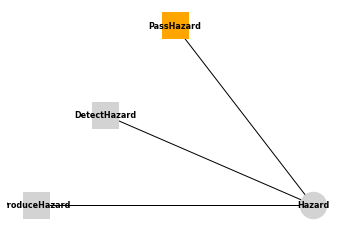

In [39]:
fig = rd.graph.show(resgraph_fault)

To see this in more detail, we will process the results history and then use `graph.results_from` at the time of the fault.

In [40]:
reshist, diff, summary = rd.process.hist(mdlhist_fault)
rd.tabulate.hist(reshist)

time ProduceHazard        DetectHazard                                   \
      t     numfaults status         mode Act_t_loc Act_mode Act_numfaults   
0     0           0.0    1.0            1         1        1             0   
1     1           0.0    1.0            1         1        1             0   
2     2           0.0    1.0            1         1        1             0   
3     3           0.0    1.0            1         1        1             0   
4     4           0.0    1.0            0         1        1             0   
..  ...           ...    ...          ...       ...      ...           ...   
56   56           0.0    1.0            1         1        1             0   
57   57           0.0    1.0            1         1        1             0   
58   58           0.0    1.0            1         1        1             0   
59   59           0.0    1.0            1         1        1             0   
60   60           0.0    1.0            1         1        1             0   

                                            ...                           \
   Act_status Perceive_t_loc Perceive_mode  ... Outcome_status numfaults   
0           1              1             1  ...              1         0   
1           1              1             1  ...              1         0   
2           1              1             1  ...              1         0   
3           1              1             1  ...              1         0   
4           1              0             1  ...              0         0   
..        ...            ...           ...  ...            ...       ...   
56          1              1             1  ...              0         0   
57          1              1             1  ...              0         0   
58          1              1             1  ...              0         0   
59          1              1             1  ...              0         0   
60          1              1             1  ...              0         0   

                 PassHazard                                      Hazard  \
   status hazards_mitigated hazards_propagated numfaults status present   
0       1                 1                  1       0.0      1       1   
1       1                 1                  1       0.0      1       1   
2       1                 1                  1       0.0      1       1   
3       1                 1                  1       0.0      1       1   
4       0                 0                  0       0.0      0       1   
..    ...               ...                ...       ...    ...     ...   
56      1                 0                  0       0.0      0       1   
57      1                 0                  0       0.0      0       1   
58      1                 0                  0       0.0      0       1   
59      1                 0                  0       0.0      0       1   
60      1                 0                  0       0.0      0       1   

                        
   percieved mitigated  
0          1         1  
1          1         1  
2          1         1  
3          1         1  
4          0         0  
..       ...       ...  
56         1         1  
57         1         1  
58         1         1  
59         1         1  
60         1         1  

[61 rows x 27 columns]

Below shows the state of the model at the given time.

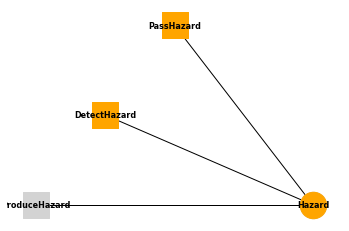

In [41]:
fig = rd.graph.result_from(mdl, reshist, 4)

We can also use `show` to view the state of the ASG. See below:

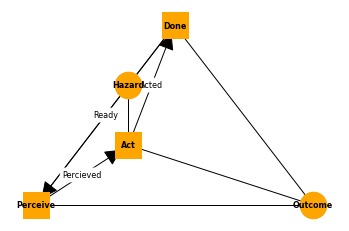

In [42]:
fig = rd.graph.result_from(mdl.fxns['DetectHazard'], reshist, 4, gtype='combined')

Note the lack of a fault at this time-step, despite it being instantiated here. This is because the fault was removed at the end of the same time-step it was added in.

The 'unable' fault, on the other hand, stays throughout the simulation and thus shows up:

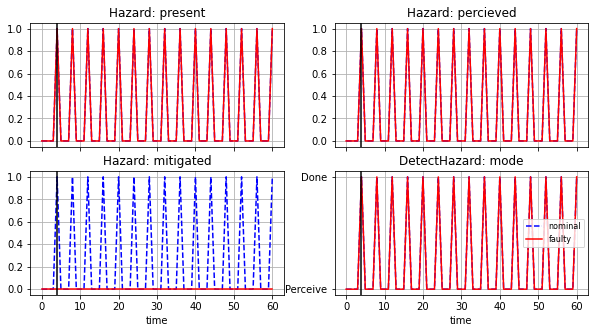

In [43]:
endstate_unable, resgraph_unable, mdlhist_unable = prop.one_fault(mdl, 'DetectHazard','act_unable', time=4)
reshist_unable, diff_unable, summary_unable = rd.process.hist(mdlhist_unable)
fig, axs = rd.plot.mdlhists(mdlhist_unable, fxnflowvals={'Hazard':'all', 'DetectHazard':'mode'}, figsize=(10,5), time_slice=[4])

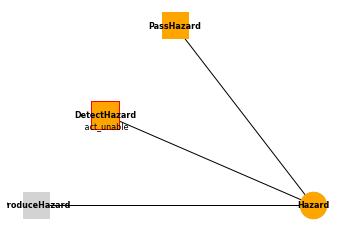

In [44]:
fig = rd.graph.result_from(mdl, reshist_unable, 4)

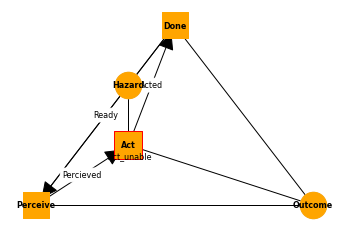

In [45]:
fig = rd.graph.result_from(mdl.fxns['DetectHazard'], reshist_unable, 4, gtype='combined')

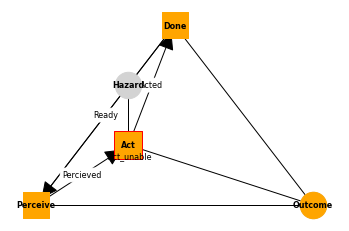

In [46]:
fig = rd.graph.result_from(mdl.fxns['DetectHazard'], reshist_unable, 6, gtype='combined')